# Caso práctico 2 COLABORATIVO 01: Deep Learning

## Sector elegido

Para el proyecto a continuación se ha seleccionado el dataset [UCI Heart Disease Data
](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data).

## Descargar dataset desde Kaggle API


Paso 1: Obtener Kaggle API Token

1. Con tu cuenta creada de Kaggle, accede a [Kaggle Settings](https://www.kaggle.com/settings)

2. Deslizate a la sección API and presiona el botón `Create New Token`. Esto bajará el archivo `kaggle.json`, el cual contiene las credenciales (username y key).

Paso 2: Instalar en Kaggle API Token

1. Carga el archivo `kaggle.json`:
   1. Google Colab
      * En Colab, click la pestaña de `Files` (ubicada en la barra lateral izquierda) > `Upload` > Seleccionas `kaggle.json` previamente generado.
      * Alternativamente, arrastra y suelta el archivo dentro del explorador archivos de la pestaña `Files`.

2. Instalar Kaggle API (si no es Google Colab)

```bash
!pip install kaggle
```

In [1]:
# Mover el token al directorio correcto con el conjunto de permisos
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

4. Descargar dataset

In [2]:
!kaggle datasets download -d redwankarimsony/heart-disease-data

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 34.2MB/s]


5. Descomprimir dataset

In [3]:
!unzip -n heart-disease-data.zip

Archive:  heart-disease-data.zip
  inflating: heart_disease_uci.csv   


## Cargar dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, OneHotEncoder

df = pd.read_csv("heart_disease_uci.csv").rename(columns={'dataset': 'origin', 'thalch': 'thalach'})
display(df.head(10))
display(df.info())
print()
print("Columnas con cantidad de valores nulos")
display(df.isnull().sum())

,id,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   origin    920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalach   865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


None


Columnas con cantidad de valores nulos


,0
id,0
age,0
sex,0
origin,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalach,55


## Limpia dataset

In [5]:
# Impute missing values (mean for numerical, mode for categorical)
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

df = df.drop(['id', 'ca', 'thal', 'slope'], axis=1)
df[num_cols] = num_imputer.fit_transform(df[num_cols]) # TODO TRUNCAR

# Fill missing values in 'exang' and convert to int after filling
df[['exang']] = cat_imputer.fit_transform(df[['exang']])
df['exang'] = df['exang'].astype(int)

# Fill missing values in 'fbs' and convert to int after filling
df['fbs'] = df['fbs'].fillna(False)
df['fbs'] = df['fbs'].astype(int)

df['restecg'] = df['restecg'].fillna('normal')

# Drop rows with remaining missing values
df = df.dropna(axis=0)

display(df.isnull().sum())

/tmp/ipython-input-130403946.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fbs'] = df['fbs'].fillna(False)


,0
age,0
sex,0
origin,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0


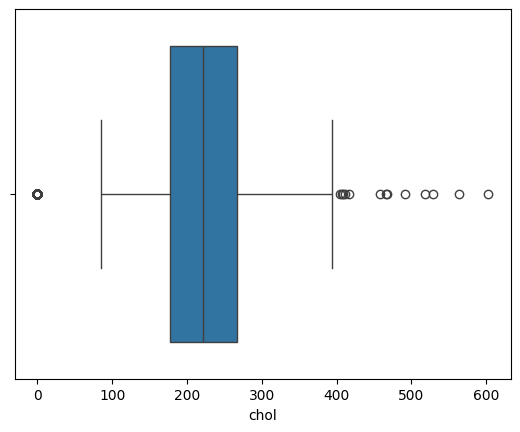

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       735 non-null    int64 
 1   sex       735 non-null    object
 2   origin    735 non-null    object
 3   cp        735 non-null    object
 4   trestbps  735 non-null    int64 
 5   chol      735 non-null    int64 
 6   fbs       735 non-null    int64 
 7   restecg   735 non-null    object
 8   thalach   735 non-null    int64 
 9   exang     735 non-null    int64 
 10  oldpeak   735 non-null    int64 
 11  num       735 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 69.0+ KB


,age,trestbps,chol,fbs,thalach,exang,oldpeak,num
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,52.892517,132.682993,240.884354,0.161905,140.914286,0.348299,0.687075,0.832653
std,9.490746,17.289928,49.300380,0.368614,24.117153,0.476756,1.008160,1.102645
min,28.000000,92.000000,85.000000,0.000000,71.000000,0.000000,0.000000,0.000000
25%,46.000000,120.000000,204.000000,0.000000,125.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,235.000000,0.000000,140.000000,0.000000,0.000000,0.000000
75%,59.000000,140.000000,273.500000,0.000000,160.000000,1.000000,1.000000,1.000000
max,77.000000,200.000000,394.000000,1.000000,202.000000,1.000000,6.000000,4.000000


In [6]:
# Check for Outliers
sns.boxplot(x=df['chol'])
plt.show()

# Handle Outliers
Q1 = df['chol'].quantile(0.25)
Q3 = df['chol'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['chol'] < (Q1 - 1.5 * IQR)) | (df['chol'] > (Q3 + 1.5 * IQR)))]

# Truncate numerics
float_columns = ['trestbps', 'chol', 'thalach', 'oldpeak', 'age']
df[float_columns] = df[float_columns].apply(lambda x: x.astype(int))

df = df.reset_index(drop=True)

df.info()
df.describe()

In [7]:
df

,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,63,Male,Cleveland,typical angina,145,233,1,lv hypertrophy,150,0,2,0
1,67,Male,Cleveland,asymptomatic,160,286,0,lv hypertrophy,108,1,1,2
2,67,Male,Cleveland,asymptomatic,120,229,0,lv hypertrophy,129,1,2,1
3,37,Male,Cleveland,non-anginal,130,250,0,normal,187,0,3,0
4,41,Female,Cleveland,atypical angina,130,204,0,lv hypertrophy,172,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
730,54,Female,VA Long Beach,asymptomatic,127,333,1,st-t abnormality,154,0,0,1
731,62,Male,VA Long Beach,typical angina,132,139,0,st-t abnormality,137,0,0,0
732,55,Male,VA Long Beach,asymptomatic,122,223,1,st-t abnormality,100,0,0,2
733,58,Male,VA Long Beach,asymptomatic,132,385,1,lv hypertrophy,137,0,0,0


In [8]:
# Encoding
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df = df.rename(columns={'sex': 'is_male'})
df = pd.get_dummies(df, columns=['origin', 'cp', 'restecg'])
df = df[[col for col in df.columns if col != 'num'] + ['num']]
df

,age,is_male,trestbps,chol,fbs,thalach,exang,oldpeak,origin_Cleveland,origin_Hungary,origin_VA Long Beach,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,num
0,63,1,145,233,1,150,0,2,True,False,False,False,False,False,True,True,False,False,0
1,67,1,160,286,0,108,1,1,True,False,False,True,False,False,False,True,False,False,2
2,67,1,120,229,0,129,1,2,True,False,False,True,False,False,False,True,False,False,1
3,37,1,130,250,0,187,0,3,True,False,False,False,False,True,False,False,True,False,0
4,41,0,130,204,0,172,0,1,True,False,False,False,True,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,54,0,127,333,1,154,0,0,False,False,True,True,False,False,False,False,False,True,1
731,62,1,132,139,0,137,0,0,False,False,True,False,False,False,True,False,False,True,0
732,55,1,122,223,1,100,0,0,False,False,True,True,False,False,False,False,False,True,2
733,58,1,132,385,1,137,0,0,False,False,True,True,False,False,False,True,False,False,0


## Explora: Analiza y Visualiza dataset

              age     is_male    trestbps        chol         fbs     thalach  \
count  735.000000  735.000000  735.000000  735.000000  735.000000  735.000000   
mean    52.892517    0.757823  132.682993  240.884354    0.161905  140.914286   
std      9.490746    0.428693   17.289928   49.300380    0.368614   24.117153   
min     28.000000    0.000000   92.000000   85.000000    0.000000   71.000000   
25%     46.000000    1.000000  120.000000  204.000000    0.000000  125.000000   
50%     54.000000    1.000000  130.000000  235.000000    0.000000  140.000000   
75%     59.000000    1.000000  140.000000  273.500000    0.000000  160.000000   
max     77.000000    1.000000  200.000000  394.000000    1.000000  202.000000   

            exang     oldpeak         num  
count  735.000000  735.000000  735.000000  
mean     0.348299    0.687075    0.832653  
std      0.476756    1.008160    1.102645  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%   

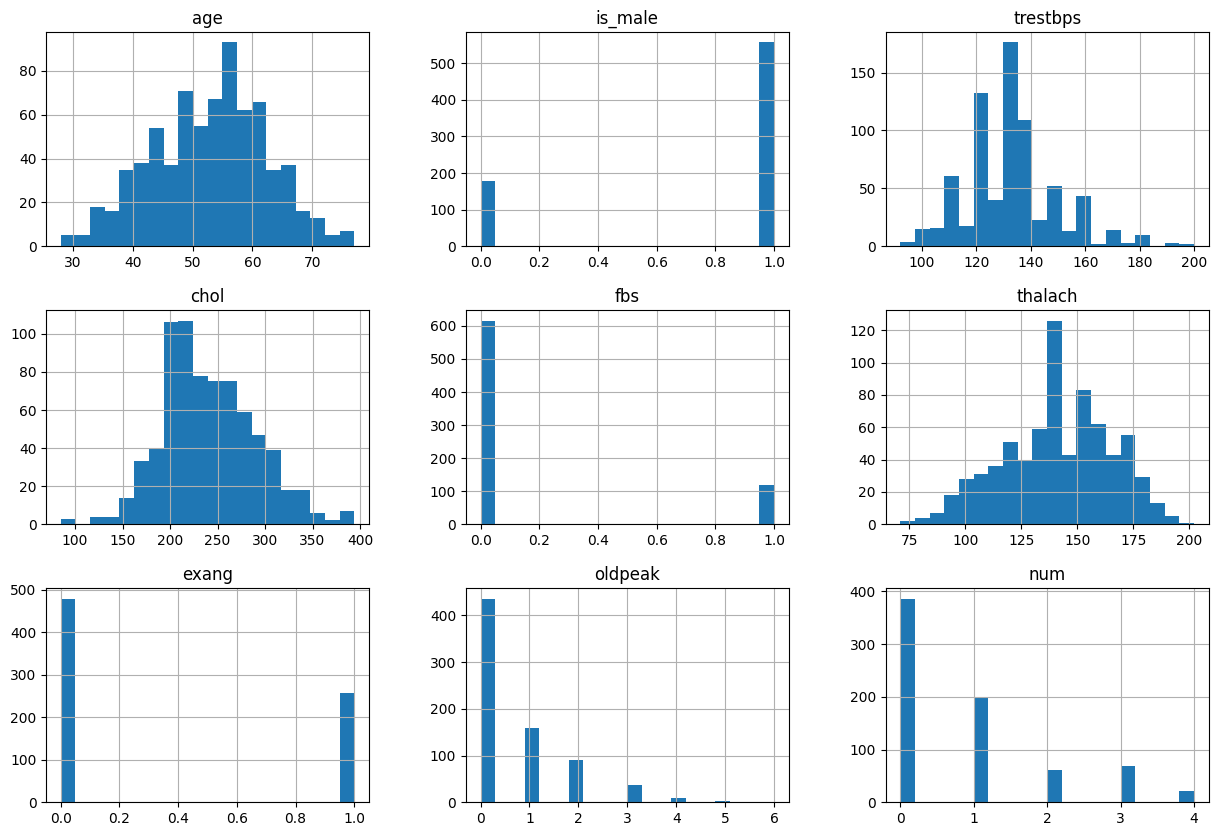

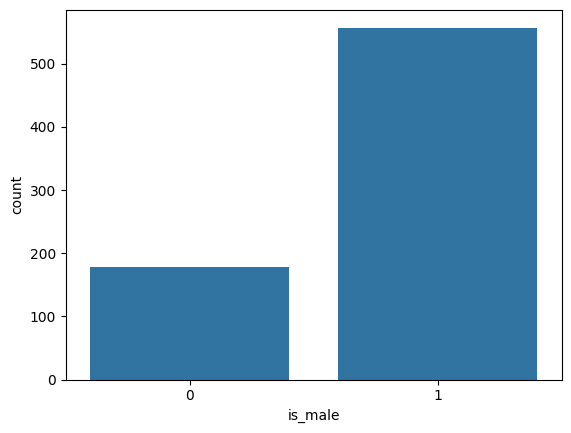

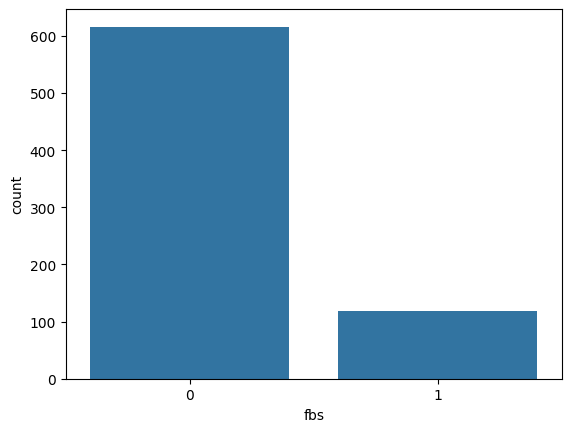

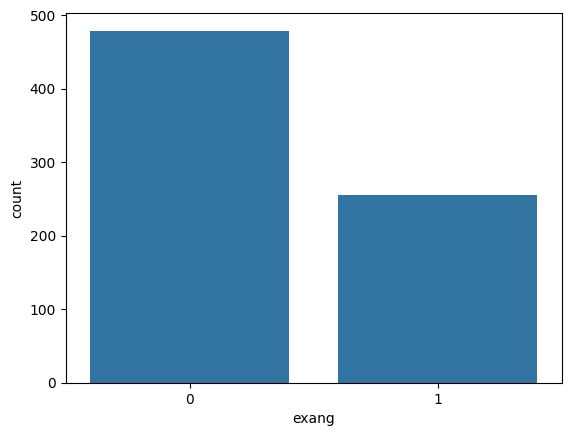

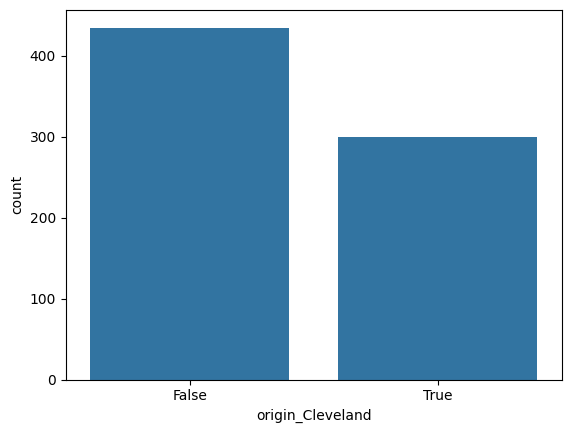

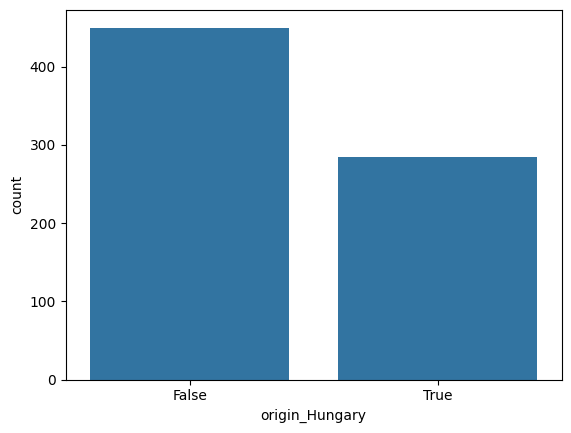

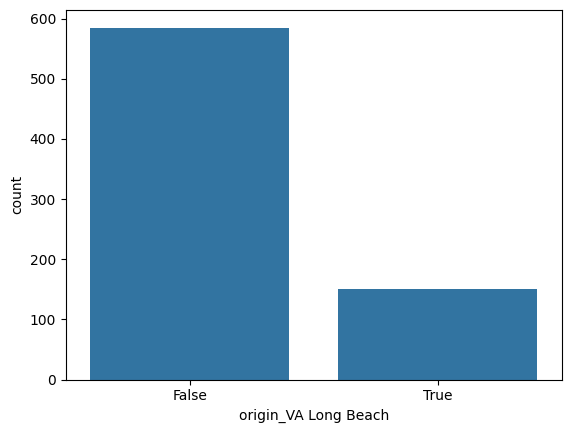

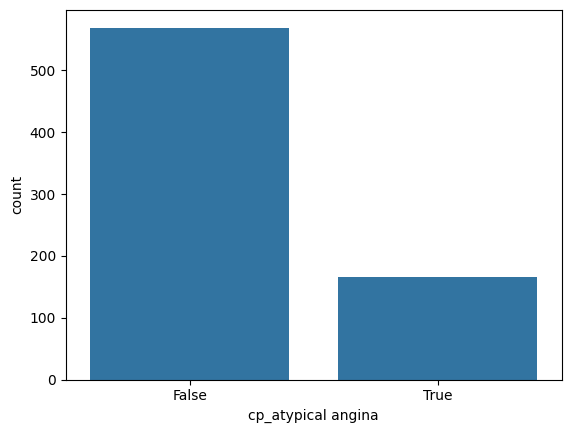

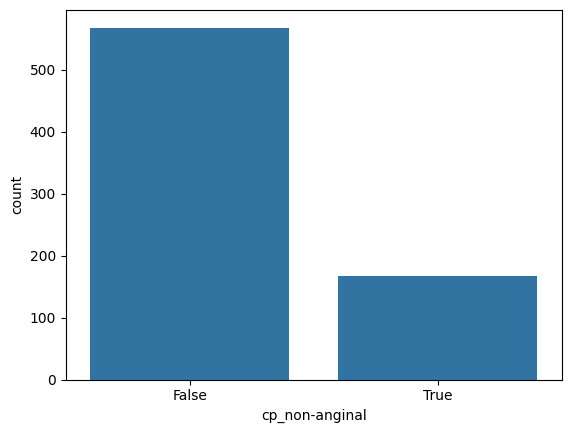

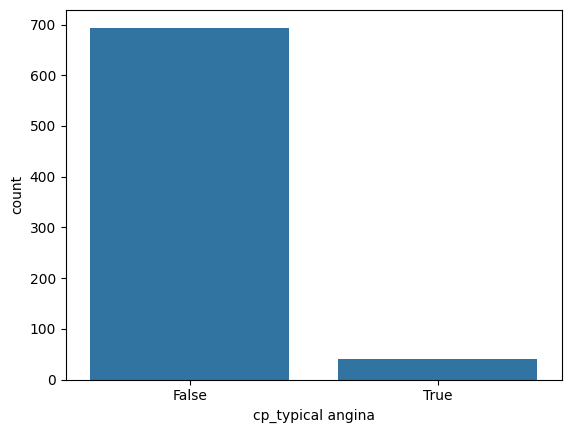

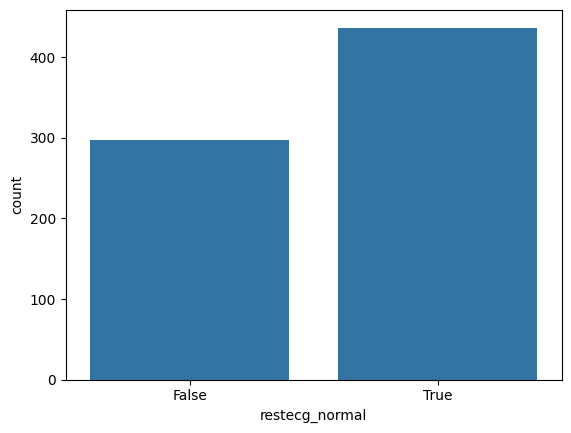

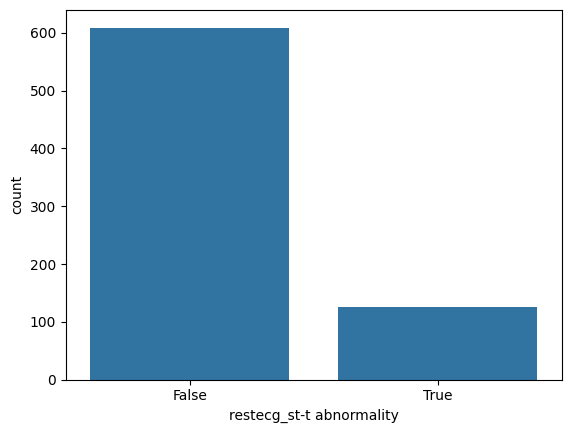

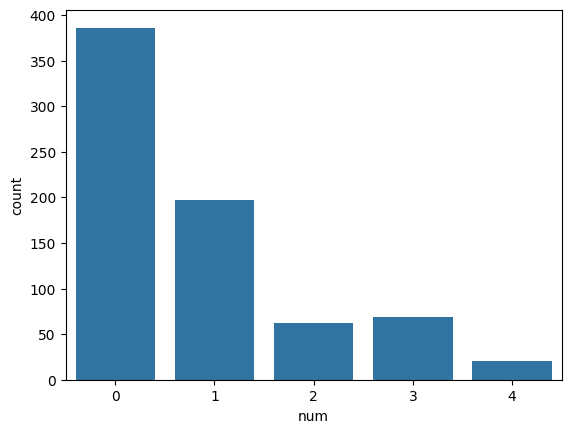

In [9]:
# Descriptive statistics
print(df.describe())
# Plot histograms for numerical features
df.hist(bins=20, figsize=(15, 10))
plt.show()
# Plot bar charts for categorical features
sns.countplot(x='is_male', data=df)
plt.show()
sns.countplot(x='fbs', data=df)
plt.show()
sns.countplot(x='exang', data=df)
plt.show()
sns.countplot(x='origin_Cleveland', data=df)
plt.show()
sns.countplot(x='origin_Hungary', data=df)
plt.show()
sns.countplot(x='origin_VA Long Beach', data=df)
plt.show()
sns.countplot(x='cp_atypical angina', data=df)
plt.show()
sns.countplot(x='cp_non-anginal', data=df)
plt.show()
sns.countplot(x='cp_typical angina', data=df)
plt.show()
sns.countplot(x='restecg_normal', data=df)
plt.show()
sns.countplot(x='restecg_st-t abnormality', data=df)
plt.show()
sns.countplot(x='num', data=df)
plt.show()

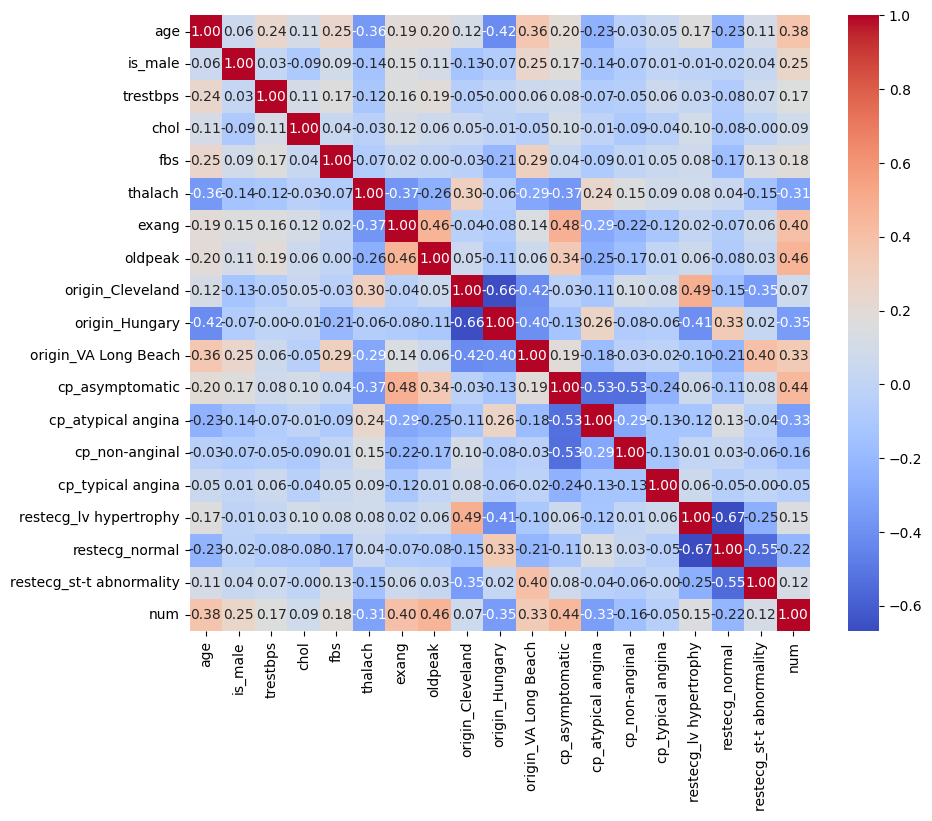

In [10]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

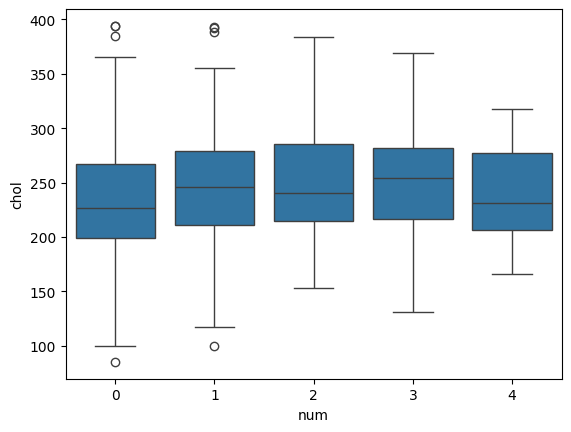

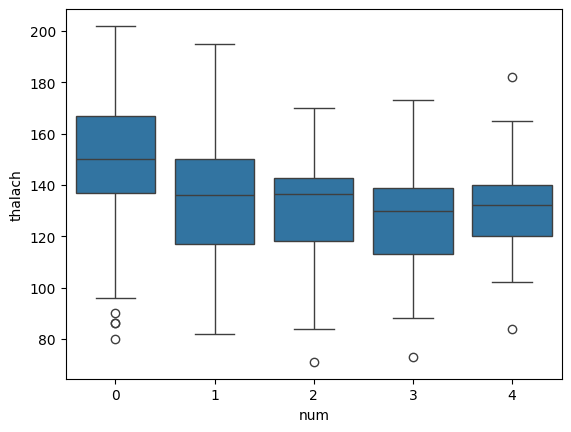

In [11]:
# Feature vs Target Analysis
sns.boxplot(x='num', y='chol', data=df)
plt.show()
sns.boxplot(x='num', y='thalach', data=df)
plt.show()

## Modela la data

In [12]:
X = df.drop(columns=["num"], axis=1)
y = df["num"]
X = SelectKBest(chi2, k=20).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data cleaned and split. Train shape:", X_train.shape)

Data cleaned and split. Train shape: (588, 18)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(


In [13]:
# 1 Hidden Layer
#  f1_score, confusion_matrix, precision_score, recall_score, classification_report
#cm = confusion_matrix(y_true, y_pred)
#sns.heatmap(cm, annot=True, fmt='d')
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
#f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", metrics.f1_score(y_test, y_pred))
print(metrics.classification_report(y_true, y_pred))
#model.predict(X_test).argmax(axis=1)


# Aplica al menos tres algoritmos ML con enfoque en "una capa" (por ejemplo: Logistic Regression, SVM, y un Perceptrón simple como NN de una capa).

NameError: name 'y_pred' is not defined

In [ ]:
#display(df["sex"].value_counts())
#display(df["origin"].value_counts())
#display(df["cp"].value_counts())
#display(df["fbs"].value_counts())
#display(df["restecg"].value_counts())
#display(df["exang"].value_counts())
#display(df["slope"].value_counts())
#display(df["ca"].value_counts())
#display(df["thal"].value_counts())
#display(df["num"].value_counts())

## Interpretacion de resultados y obtencion informacion

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()